In [1]:
import os
import os.path as osp
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import (NNConv, graclus, max_pool, max_pool_x,
                                global_mean_pool)

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

from datasets.hitgraphs import HitGraphDataset

import tqdm
import argparse

In [2]:
directed = False
sig_weight = 1.0
bkg_weight = 1.0
train_batch_size = 1
valid_batch_size = 1
n_epochs = 20
lr = 0.01
hidden_dim = 64
n_iters = 6


In [3]:
from training.gnn2 import GNNTrainer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device %s'%device)
import logging

using device cuda


In [4]:
#path = osp.join(os.environ['GNN_TRAINING_DATA_ROOT'], args.dataset)
path ='/home/sameasy2006/npz_hgcal_pionaddsiminfo_all_k8/pion_hgctup_0to1000'
print(path)
full_dataset = HitGraphDataset(path, directed=directed, categorical=True)
fulllen = len(full_dataset)
tv_frac = 0.20
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-tv_num,0,tv_num])
print(fulllen, splits)



/home/sameasy2006/npz_hgcal_pionaddsiminfo_all_k8/pion_hgctup_0to1000
Processing...


100%|██████████| 14146/14146 [45:37<00:00,  5.17it/s] 

Done!
14146 [11316 11316 14146]


In [ ]:
train_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=0,stop=splits[0]))
#train_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=0,stop=5))
valid_dataset = torch.utils.data.Subset(full_dataset,np.arange(start=splits[1],stop=splits[2]))
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

d = full_dataset
num_features = d.num_features
num_classes = d[0].y.dim() if d[0].y.dim() == 1 else d[0].y.size(1)

#if args.categorized:
#    if not args.forcecats:
#       num_classes = int(d[0].y.max().item()) + 1 if d[0].y.dim() == 1 else d[0].y.size(1)
#    else:
#        num_classes = args.cats
num_classes = 4
print ('num_classes',num_classes)
the_weights = np.array([1., 1., 1., 1.]) #[0.017, 1., 1., 10.]
#the_weights = np.array([1,1]) #[0.017, 1., 1., 10.]
trainer = GNNTrainer(category_weights = the_weights, 
                     output_dir='/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/output_HGC_pion_all_8nn_siminfo', device=device)
#                    output_dir='/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/testtest', device=device)
                     
                     
trainer.logger.setLevel(logging.DEBUG)
strmH = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
strmH.setFormatter(formatter)
trainer.logger.addHandler(strmH)

#example lr scheduling definition
def lr_scaling(optimizer):
    from torch.optim.lr_scheduler import ReduceLROnPlateau        
    return ReduceLROnPlateau(optimizer, mode='min', verbose=True,
                             min_lr=5e-7, factor=0.2, 
                             threshold=0.01, patience=5)


trainer.build_model(name='EdgeNetWithCategories', loss_func='nll_loss',
                    optimizer='AdamW', learning_rate=0.001, lr_scaling=lr_scaling,
                    input_dim=num_features, hidden_dim=64, n_iters=6,
                    output_dim=num_classes)

trainer.print_model_summary()

train_summary = trainer.train(train_loader, n_epochs, valid_data_loader=valid_loader)

print(train_summary)
    
'''
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--categorized', '-c', action='store_true', default=False, help='Does the model you want to train have explicit categories?')
    parser.add_argument('--forcecats', action='store_true', default=False, help='Do we want to force the number of categories?')
    parser.add_argument('--cats', default=1, type=int, help='Number of categories to force')
    parser.add_argument('--optimizer', '-o', default='Adam', help='Optimizer to use for training.')
    parser.add_argument('--model', '-m', default='EdgeNet2', help='The model to train.')
    parser.add_argument('--loss', '-l', default='binary_cross_entropy', help='Loss function to use in training.')
    parser.add_argument('--lr', default=0.001, type=float, help='The starting learning rate.')
    parser.add_argument('--hidden_dim', default=64, type=int, help='Latent space size.')
    parser.add_argument('--n_iters', default=6, type=int, help='Number of times to iterate the graph.')
    parser.add_argument('--dataset', '-d', default='single_photon')
    
    args = parser.parse_args()
    main(args)
'''                                                


num_classes 4


2020-02-19 22:08:13,374 - GNNTrainer - INFO - Model: 
EdgeNetWithCategories(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): LogSoftmax()
  )
  (nodenetwork0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=101, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (nodenetwork1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1

In [6]:
path = osp.join(os.environ['GNN_TRAINING_DATA_ROOT'], 'photon_hfntup_0to1000')
print(path)

/home/sameasy2006/training_data/photon_hfntup_0to1000


In [7]:
epochs= [0, 1, 2, 3, 4, 5, 6]
lrs= [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001] 
train_times= [225.54388546943665, 225.22212648391724, 225.3216323852539, 225.35716199874878, 225.40882205963135, 225.19546961784363, 225.20603489875793] 
train_losss= [0.04032796977131486, 0.015438518584319796, 0.012363892024644151, 0.008919628991402343, 0.0075437994571782635, 0.00695315887611514, 0.0066568848183646955] 
valid_times= [19.107330799102783, 19.0887508392334, 19.067117929458618, 19.119823217391968, 19.130934476852417, 19.135619401931763, 19.068397998809814]
valid_losss= [0.017775222663031956, 0.014626435511804124, 0.010906822071867673, 0.007683055135360127, 0.006854731867877541, 0.006997309575743, 0.007357149830413887]
valid_accs=[0.9932499189329411, 0.9944335828067422, 0.9956929219621333, 0.9973105070697365, 0.9977536107685164, 0.997650872746129, 0.9975113442820626]

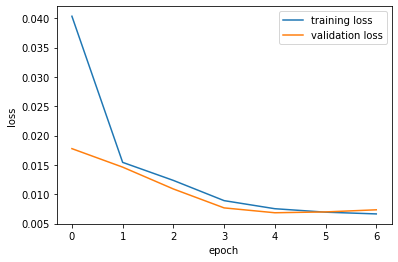

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs,train_losss,label='training loss')
plt.plot(epochs,valid_losss,label='validation loss')
plt.xlabel('epoch') 
plt.ylabel('loss')
plt.legend()
plt.show()

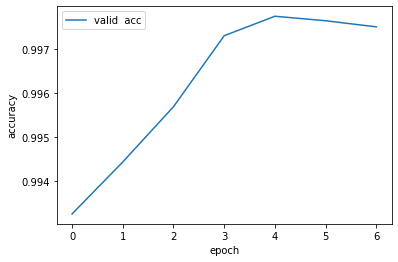

In [9]:
plt.plot(epochs,valid_accs,label='valid  acc')
#plt.plot(epochs,valid_losss,label='validation loss')
plt.xlabel('epoch') 
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [10]:
a=torch.tensor([0.7523, 0.7523, 0.7496])
b=torch.tensor([1., 1., 1.])

In [11]:
c = ((a<0)==(b<0))
c.numel()

3

In [12]:
'''
the_weights = np.array([0.017,1])

2020-02-02 09:15:52,559 - GNNTrainer - INFO - Epoch 10
loss = 0.00050: 100%|██████████| 11520/11520 [04:59<00:00, 38.45it/s]
2020-02-02 09:20:52,147 - GNNTrainer - DEBUG -  Processed 11520 batches
2020-02-02 09:20:52,148 - GNNTrainer - INFO -   Training loss: 0.00052
2020-02-02 09:20:52,148 - GNNTrainer - INFO -   Learning rate: 0.00100
100%|██████████| 2880/2880 [00:28<00:00, 100.21it/s]
2020-02-02 09:21:20,912 - GNNTrainer - DEBUG -  Processed 2880 samples in 2880 batches
2020-02-02 09:21:20,912 - GNNTrainer - INFO -   Validation loss: 0.020 acc: 0.993
2020-02-02 09:21:20,913 - GNNTrainer - INFO -   signal_efficiency: 0.998849 background_efficiency: 0.993102
2020-02-02 09:21:20,913 - GNNTrainer - INFO -   signal_purity: 0.821057 background_purity: 0.999963
'''

'\nthe_weights = np.array([0.017,1])\n\n2020-02-02 09:15:52,559 - GNNTrainer - INFO - Epoch 10\nloss = 0.00050: 100%|██████████| 11520/11520 [04:59<00:00, 38.45it/s]\n2020-02-02 09:20:52,147 - GNNTrainer - DEBUG -  Processed 11520 batches\n2020-02-02 09:20:52,148 - GNNTrainer - INFO -   Training loss: 0.00052\n2020-02-02 09:20:52,148 - GNNTrainer - INFO -   Learning rate: 0.00100\n100%|██████████| 2880/2880 [00:28<00:00, 100.21it/s]\n2020-02-02 09:21:20,912 - GNNTrainer - DEBUG -  Processed 2880 samples in 2880 batches\n2020-02-02 09:21:20,912 - GNNTrainer - INFO -   Validation loss: 0.020 acc: 0.993\n2020-02-02 09:21:20,913 - GNNTrainer - INFO -   signal_efficiency: 0.998849 background_efficiency: 0.993102\n2020-02-02 09:21:20,913 - GNNTrainer - INFO -   signal_purity: 0.821057 background_purity: 0.999963\n'

In [13]:
'''


2020-02-02 10:11:51,495 - GNNTrainer - INFO - Epoch 8
loss = 0.00047: 100%|██████████| 11520/11520 [04:59<00:00, 38.45it/s]
2020-02-02 10:16:51,110 - GNNTrainer - DEBUG -  Processed 11520 batches
2020-02-02 10:16:51,110 - GNNTrainer - INFO -   Training loss: 0.00052
2020-02-02 10:16:51,111 - GNNTrainer - INFO -   Learning rate: 0.00100
100%|██████████| 2880/2880 [00:28<00:00, 100.22it/s]
2020-02-02 10:17:19,872 - GNNTrainer - DEBUG -  Processed 2880 samples in 2880 batches
2020-02-02 10:17:19,873 - GNNTrainer - INFO -   Validation loss: 0.019 acc: 0.994
2020-02-02 10:17:19,874 - GNNTrainer - INFO -   signal_efficiency: 0.998442 background_efficiency: 0.993346
2020-02-02 10:17:19,874 - GNNTrainer - INFO -   signal_purity: 0.826232 background_purity: 0.999950
2020-02-02 10:17:19,875 - GNNTrainer - DEBUG - Checkpointing new best model with loss: 0.01923

'''

'\n\n\n2020-02-02 10:11:51,495 - GNNTrainer - INFO - Epoch 8\nloss = 0.00047: 100%|██████████| 11520/11520 [04:59<00:00, 38.45it/s]\n2020-02-02 10:16:51,110 - GNNTrainer - DEBUG -  Processed 11520 batches\n2020-02-02 10:16:51,110 - GNNTrainer - INFO -   Training loss: 0.00052\n2020-02-02 10:16:51,111 - GNNTrainer - INFO -   Learning rate: 0.00100\n100%|██████████| 2880/2880 [00:28<00:00, 100.22it/s]\n2020-02-02 10:17:19,872 - GNNTrainer - DEBUG -  Processed 2880 samples in 2880 batches\n2020-02-02 10:17:19,873 - GNNTrainer - INFO -   Validation loss: 0.019 acc: 0.994\n2020-02-02 10:17:19,874 - GNNTrainer - INFO -   signal_efficiency: 0.998442 background_efficiency: 0.993346\n2020-02-02 10:17:19,874 - GNNTrainer - INFO -   signal_purity: 0.826232 background_purity: 0.999950\n2020-02-02 10:17:19,875 - GNNTrainer - DEBUG - Checkpointing new best model with loss: 0.01923\n\n'